# Data Loader for DIV2K HR / LR Pairs

In [1]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

class DIV2KSequence(Sequence):
    def __init__(self, hr_dir, lr_dir, batch_size=16, patch_size=64, scale=4):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.batch_size = batch_size
        self.patch_size = patch_size  # LR patch size
        self.scale = scale  # X4
        self.hr_patch_size = patch_size * scale
        
        self.image_names = sorted(os.listdir(lr_dir))  # All images are paired by name

    def __len__(self):
        return len(self.image_names) // self.batch_size

    def __getitem__(self, idx):
        batch_hr = []
        batch_lr = []

        batch_files = self.image_names[idx * self.batch_size:(idx + 1) * self.batch_size]
        for fname in batch_files:
            hr_fname = fname[:4] + ".png"
            hr_path = os.path.join(self.hr_dir, hr_fname)
            lr_path = os.path.join(self.lr_dir, fname)

            hr_img = img_to_array(load_img(hr_path))  # shape: (H, W, 3)
            lr_img = img_to_array(load_img(lr_path))  # shape: (H/4, W/4, 3)

            # Extract matching patches from LR and HR
            h, w, _ = lr_img.shape
            if h < self.patch_size or w < self.patch_size:
                continue  # skip small images

            # Random top-left corner
            x = random.randint(0, w - self.patch_size)
            y = random.randint(0, h - self.patch_size)

            # LR patch
            lr_patch = lr_img[y:y+self.patch_size, x:x+self.patch_size, :]

            # HR patch at the corresponding location
            hr_x = x * self.scale
            hr_y = y * self.scale
            hr_patch = hr_img[hr_y:hr_y+self.hr_patch_size, hr_x:hr_x+self.hr_patch_size, :]

            # Normalize to [-1, 1]
            lr_patch = (lr_patch / 127.5) - 1.0
            hr_patch = (hr_patch / 127.5) - 1.0

            batch_lr.append(lr_patch)
            batch_hr.append(hr_patch)

        return np.array(batch_lr), np.array(batch_hr)


2025-06-23 16:46:02.548985: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 16:46:02.557734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750697162.567388    1046 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750697162.570399    1046 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750697162.577832    1046 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Test the DIV2KSequence Generator

In [2]:
import matplotlib.pyplot as plt

# Change to your actual paths
hr_dir = "./datasets/DIV2K/DIV2K_train_HR"
lr_dir = "./datasets/DIV2K/DIV2K_train_LR_bicubic/X4"

# Instantiate generator
gen = DIV2KSequence(hr_dir=hr_dir, lr_dir=lr_dir, batch_size=4, patch_size=64, scale=4)

# Load one batch
lr_batch, hr_batch = gen[0]

print("LR batch shape:", lr_batch.shape)  # Expected: (4, 64, 64, 3)
print("HR batch shape:", hr_batch.shape)  # Expected: (4, 256, 256, 3)

print("LR pixel value range: [{:.2f}, {:.2f}]".format(lr_batch.min(), lr_batch.max()))
print("HR pixel value range: [{:.2f}, {:.2f}]".format(hr_batch.min(), hr_batch.max()))

LR batch shape: (4, 64, 64, 3)
HR batch shape: (4, 256, 256, 3)
LR pixel value range: [-0.99, 0.91]
HR pixel value range: [-1.00, 1.00]


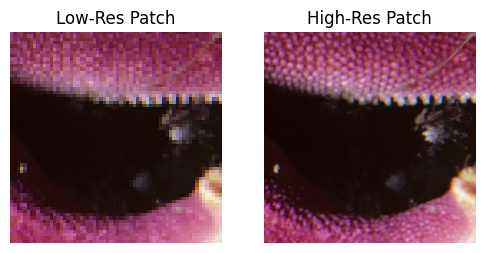

In [3]:
# Denormalize for display
def denormalize(img):
    return ((img + 1.0) * 127.5).astype("uint8")

# Show first image in batch
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Low-Res Patch")
plt.imshow(denormalize(lr_batch[i]))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("High-Res Patch")
plt.imshow(denormalize(hr_batch[i]))
plt.axis("off")
plt.show()

# Build the Generator in Keras

In [4]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Add, Input, UpSampling2D, PReLU
from tensorflow.keras.models import Model

def residual_block(input_tensor, filters):
    x = Conv2D(filters, kernel_size=3, padding='same')(input_tensor)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    return Add()([input_tensor, x])

def build_generator_lite(input_shape=(64, 64, 3), num_res_blocks=4):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    residual = x

    # Lightweight Residual Blocks
    for _ in range(num_res_blocks):
        residual = residual_block(residual, 64)

    # Convolution after residual blocks
    x = Conv2D(64, kernel_size=3, padding='same')(residual)
    x = Add()([x, residual])

    # Upsampling blocks
    for _ in range(2):  # 2x2 = 4x scale
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding='same')(x)
        x = PReLU(shared_axes=[1, 2])(x)

    # Final output layer
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)

    return Model(inputs, outputs)

# Visualize Generator Output from a Real DIV2K LR Image

I0000 00:00:1750697169.238902    1046 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1750697170.095903    1194 service.cc:152] XLA service 0x72f7bc00aa90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750697170.095928    1194 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-23 16:46:10.105545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750697170.159475    1194 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-23 16:46:20.991459: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.60 = (f32[1,64,1332,2040]{

I0000 00:00:1750697194.968774    1194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


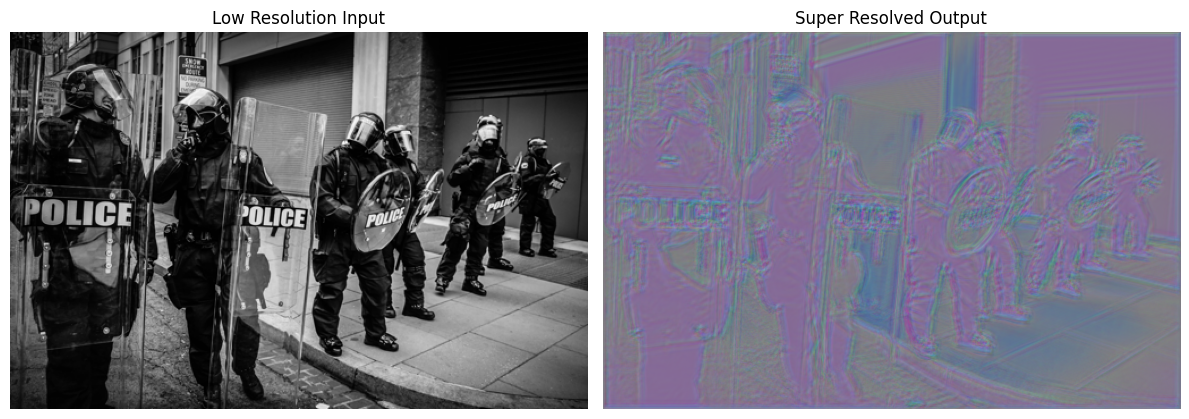

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Load your custom generator model
generator = build_generator_lite(input_shape=(None, None, 3))  # allow flexible image size

# Optional: Load pretrained weights if available
# generator.load_weights("generator_weights.h5")

# Path to a sample low-resolution image (from DIV2K_train_LR_bicubic/X4)
sample_lr_path = os.path.join("./datasets/DIV2K/DIV2K_train_LR_bicubic/X4", "0800x4.png")

# Load and preprocess the LR image
lr_img = Image.open(sample_lr_path).convert("RGB")
lr_array = np.array(lr_img).astype(np.float32)
lr_norm = (lr_array / 127.5) - 1.0  # Normalize to [-1, 1]
lr_input = np.expand_dims(lr_norm, axis=0)  # Add batch dimension

# Generate the super-resolved (HR) image
sr_output = generator.predict(lr_input)[0]  # Remove batch dimension

# Post-process: denormalize to [0, 255] and convert to uint8
sr_image = ((sr_output + 1) * 127.5).clip(0, 255).astype(np.uint8)

# Display the LR input and SR output side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lr_array.astype(np.uint8))
plt.title("Low Resolution Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sr_image)
plt.title("Super Resolved Output")
plt.axis("off")

plt.tight_layout()
plt.show()

# Visualize Generator Output from a Real DIV2K LR Image

In [6]:
def build_discriminator_lite(input_shape=(256, 256, 3)):
    from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, GlobalAveragePooling2D, Dense
    from tensorflow.keras.models import Model

    def conv_block(x, filters, strides=1):
        x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    inp = Input(shape=input_shape)
    x = conv_block(inp, 64, strides=2)
    x = conv_block(x, 128, strides=2)
    x = conv_block(x, 256, strides=2)
    x = conv_block(x, 512, strides=2)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)


In [7]:
import tensorflow as tf

# Build the discriminator model
discriminator = build_discriminator_lite(input_shape=(256, 256, 3))

# Create a dummy HR image patch (batch size = 1)
dummy_hr = tf.random.normal((1, 256, 256, 3))  # Shape must match discriminator input

# Get discriminator output
decision = discriminator(dummy_hr)

# Print output
print("Discriminator output shape:", decision.shape)
print("Discriminator decision (probability):", decision.numpy())

Discriminator output shape: (1, 1)
Discriminator decision (probability): [[0.49334666]]


# Train Discriminator

In [8]:
import tensorflow as tf

# Binary crossentropy loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Optimizer for discriminator
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9)

# Build your generator and discriminator
generator = build_generator_lite(input_shape=(64, 64, 3))
discriminator = build_discriminator_lite(input_shape=(256, 256, 3))

@tf.function
def train_discriminator_step(lr_imgs, hr_imgs):
    # Step 1: Generate super-resolved images from LR input (don't update generator)
    sr_imgs = generator(lr_imgs, training=False)  # Freeze generator

    with tf.GradientTape() as tape:
        # Step 2: Get discriminator outputs
        real_output = discriminator(hr_imgs, training=True)
        fake_output = discriminator(sr_imgs, training=True)

        # Step 3: Create labels
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)

        # Step 4: Compute binary crossentropy loss
        d_loss_real = bce(real_labels, real_output)
        d_loss_fake = bce(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake

    # Step 5: Update discriminator weights only
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return d_loss

# Train the Generator

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Optimizer for generator
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9)

# Losses
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse = tf.keras.losses.MeanSquaredError()

# VGG19 feature extractor for perceptual loss (feature layer: block5_conv4)
def build_vgg():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    return model

# Instantiate VGG model once
vgg = build_vgg()

@tf.function
def train_generator_step(lr_imgs, hr_imgs):
    with tf.GradientTape() as tape:
        # Step 1: Generate SR images from LR input
        sr_imgs = generator(lr_imgs, training=True)

        # Step 2: Discriminator output for fake images
        fake_output = discriminator(sr_imgs, training=False)  # Freeze discriminator

        # Step 3: Adversarial loss
        adversarial_loss = bce(tf.ones_like(fake_output), fake_output)

        # Step 4: VGG perceptual loss
        sr_features = vgg(sr_imgs)
        hr_features = vgg(hr_imgs)
        perceptual_loss = mse(hr_features, sr_features)

        # Step 5: Total generator loss
        gen_loss = perceptual_loss + 1e-3 * adversarial_loss

    # Step 6: Update generator weights
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return gen_loss

# Training Loop

In [10]:
import tensorflow as tf
from tqdm import tqdm

# Define paths to your dataset folders
hr_dir = "./datasets/DIV2K/DIV2K_train_HR"
lr_dir = "./datasets/DIV2K/DIV2K_train_LR_bicubic/X4"

# Create the data generator (Sequence)
train_loader = DIV2KSequence(hr_dir=hr_dir, lr_dir=lr_dir, batch_size=16, patch_size=64, scale=4)

# Hyperparameters
epochs = 50
steps_per_epoch = len(train_loader)  # train_loader = instance of DIV2KSequence
save_every = 5  # Save model every N epochs

# Loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    d_losses = []
    g_losses = []

    for step in tqdm(range(steps_per_epoch)):
        # Get batch
        lr_imgs, hr_imgs = train_loader[step]

        # Convert to tensors (in case not already)
        lr_imgs = tf.convert_to_tensor(lr_imgs, dtype=tf.float32)
        hr_imgs = tf.convert_to_tensor(hr_imgs, dtype=tf.float32)

        # Train discriminator
        d_loss = train_discriminator_step(lr_imgs, hr_imgs)
        d_losses.append(d_loss.numpy())

        # Train generator
        g_loss = train_generator_step(lr_imgs, hr_imgs)
        g_losses.append(g_loss.numpy())

    # Epoch summary
    print(f"Epoch {epoch + 1}: D Loss = {sum(d_losses)/len(d_losses):.4f}, G Loss = {sum(g_losses)/len(g_losses):.4f}")

    # Save models
    if (epoch + 1) % save_every == 0:
        generator.save_weights(f"generator_epoch_{epoch + 1}.weights.h5")
        discriminator.save_weights(f"discriminator_epoch_{epoch + 1}.weights.h5")
        print(f"✅ Saved model weights at epoch {epoch + 1}")


Epoch 1/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [04:03<00:00,  4.87s/it]


Epoch 1: D Loss = 0.6311, G Loss = 0.0547

Epoch 2/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.16s/it]


Epoch 2: D Loss = 0.1939, G Loss = 0.0469

Epoch 3/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:39<00:00,  3.19s/it]


Epoch 3: D Loss = 0.1381, G Loss = 0.0401

Epoch 4/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [03:41<00:00,  4.42s/it]


Epoch 4: D Loss = 0.2332, G Loss = 0.0375

Epoch 5/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:45<00:00,  3.31s/it]


Epoch 5: D Loss = 0.2597, G Loss = 0.0347
✅ Saved model weights at epoch 5

Epoch 6/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Epoch 6: D Loss = 0.1244, G Loss = 0.0320

Epoch 7/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.78s/it]


Epoch 7: D Loss = 0.1516, G Loss = 0.0297

Epoch 8/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:06<00:00,  2.53s/it]


Epoch 8: D Loss = 0.1505, G Loss = 0.0283

Epoch 9/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.84s/it]


Epoch 9: D Loss = 0.7089, G Loss = 0.0283

Epoch 10/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.81s/it]


Epoch 10: D Loss = 0.9795, G Loss = 0.0281
✅ Saved model weights at epoch 10

Epoch 11/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:16<00:00,  2.73s/it]


Epoch 11: D Loss = 0.8862, G Loss = 0.0266

Epoch 12/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:13<00:00,  2.67s/it]


Epoch 12: D Loss = 0.6930, G Loss = 0.0258

Epoch 13/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.68s/it]


Epoch 13: D Loss = 0.8295, G Loss = 0.0253

Epoch 14/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.56s/it]


Epoch 14: D Loss = 0.5888, G Loss = 0.0247

Epoch 15/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.84s/it]


Epoch 15: D Loss = 0.6291, G Loss = 0.0252
✅ Saved model weights at epoch 15

Epoch 16/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.62s/it]


Epoch 16: D Loss = 0.4375, G Loss = 0.0243

Epoch 17/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:08<00:00,  2.57s/it]


Epoch 17: D Loss = 0.3501, G Loss = 0.0234

Epoch 18/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:13<00:00,  2.67s/it]


Epoch 18: D Loss = 0.2854, G Loss = 0.0235

Epoch 19/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:55<00:00,  2.32s/it]


Epoch 19: D Loss = 0.2198, G Loss = 0.0237

Epoch 20/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.78s/it]


Epoch 20: D Loss = 0.1400, G Loss = 0.0227
✅ Saved model weights at epoch 20

Epoch 21/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.63s/it]


Epoch 21: D Loss = 0.0772, G Loss = 0.0227

Epoch 22/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:03<00:00,  2.47s/it]


Epoch 22: D Loss = 0.0787, G Loss = 0.0223

Epoch 23/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.61s/it]


Epoch 23: D Loss = 0.0502, G Loss = 0.0221

Epoch 24/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.62s/it]


Epoch 24: D Loss = 0.0584, G Loss = 0.0223

Epoch 25/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.24s/it]


Epoch 25: D Loss = 0.0563, G Loss = 0.0217
✅ Saved model weights at epoch 25

Epoch 26/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.78s/it]


Epoch 26: D Loss = 0.0535, G Loss = 0.0218

Epoch 27/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:05<00:00,  2.51s/it]


Epoch 27: D Loss = 0.0361, G Loss = 0.0202

Epoch 28/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:06<00:00,  2.52s/it]


Epoch 28: D Loss = 0.0516, G Loss = 0.0213

Epoch 29/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:08<00:00,  2.56s/it]


Epoch 29: D Loss = 0.0470, G Loss = 0.0213

Epoch 30/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:48<00:00,  3.38s/it]


Epoch 30: D Loss = 0.0940, G Loss = 0.0214
✅ Saved model weights at epoch 30

Epoch 31/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:32<00:00,  3.06s/it]


Epoch 31: D Loss = 0.0892, G Loss = 0.0212

Epoch 32/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:37<00:00,  3.15s/it]


Epoch 32: D Loss = 0.1692, G Loss = 0.0214

Epoch 33/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.77s/it]


Epoch 33: D Loss = 0.0891, G Loss = 0.0207

Epoch 34/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.83s/it]


Epoch 34: D Loss = 0.0337, G Loss = 0.0201

Epoch 35/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.68s/it]


Epoch 35: D Loss = 0.0257, G Loss = 0.0202
✅ Saved model weights at epoch 35

Epoch 36/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:22<00:00,  2.85s/it]


Epoch 36: D Loss = 0.0189, G Loss = 0.0197

Epoch 37/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:12<00:00,  2.65s/it]


Epoch 37: D Loss = 0.0269, G Loss = 0.0206

Epoch 38/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:17<00:00,  2.75s/it]


Epoch 38: D Loss = 0.0339, G Loss = 0.0195

Epoch 39/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:22<00:00,  2.85s/it]


Epoch 39: D Loss = 0.0587, G Loss = 0.0201

Epoch 40/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:12<00:00,  2.66s/it]


Epoch 40: D Loss = 0.0261, G Loss = 0.0195
✅ Saved model weights at epoch 40

Epoch 41/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.77s/it]


Epoch 41: D Loss = 0.1470, G Loss = 0.0202

Epoch 42/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:16<00:00,  2.73s/it]


Epoch 42: D Loss = 0.0418, G Loss = 0.0198

Epoch 43/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/it]


Epoch 43: D Loss = 0.1005, G Loss = 0.0203

Epoch 44/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.79s/it]


Epoch 44: D Loss = 0.0518, G Loss = 0.0194

Epoch 45/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:13<00:00,  2.67s/it]


Epoch 45: D Loss = 0.0185, G Loss = 0.0187
✅ Saved model weights at epoch 45

Epoch 46/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:17<00:00,  2.74s/it]


Epoch 46: D Loss = 0.0142, G Loss = 0.0190

Epoch 47/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.80s/it]


Epoch 47: D Loss = 0.0113, G Loss = 0.0197

Epoch 48/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.78s/it]


Epoch 48: D Loss = 0.0789, G Loss = 0.0189

Epoch 49/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:39<00:00,  3.19s/it]


Epoch 49: D Loss = 0.1775, G Loss = 0.0188

Epoch 50/50


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:08<00:00,  2.58s/it]

Epoch 50: D Loss = 0.0191, G Loss = 0.0190
✅ Saved model weights at epoch 50


In [20]:
# Continue training for 30 more epochs (from epoch 51 to 80)
additional_epochs = 30
start_epoch = 50
save_every = 5

for epoch in range(start_epoch, start_epoch + additional_epochs):
    print(f"\nEpoch {epoch + 1}/{start_epoch + additional_epochs}")
    d_losses = []
    g_losses = []

    for step in tqdm(range(steps_per_epoch)):
        lr_imgs, hr_imgs = train_loader[step]
        lr_imgs = tf.convert_to_tensor(lr_imgs, dtype=tf.float32)
        hr_imgs = tf.convert_to_tensor(hr_imgs, dtype=tf.float32)

        # Train discriminator and generator
        d_loss = train_discriminator_step(lr_imgs, hr_imgs)
        g_loss = train_generator_step(lr_imgs, hr_imgs)

        d_losses.append(d_loss.numpy())
        g_losses.append(g_loss.numpy())

    print(f"Epoch {epoch + 1}: D Loss = {sum(d_losses)/len(d_losses):.4f}, G Loss = {sum(g_losses)/len(g_losses):.4f}")

    # Save weights every 5 epochs
    if (epoch + 1) % save_every == 0:
        generator.save_weights(f"generator_epoch_{epoch + 1}.weights.h5")
        discriminator.save_weights(f"discriminator_epoch_{epoch + 1}.weights.h5")
        print(f"✅ Saved model weights at epoch {epoch + 1}")



Epoch 51/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [03:21<00:00,  4.03s/it]


Epoch 51: D Loss = 0.0133, G Loss = 0.0183

Epoch 52/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.70s/it]


Epoch 52: D Loss = 0.0110, G Loss = 0.0189

Epoch 53/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]


Epoch 53: D Loss = 0.0127, G Loss = 0.0190

Epoch 54/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]


Epoch 54: D Loss = 0.0125, G Loss = 0.0181

Epoch 55/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:09<00:00,  2.58s/it]


Epoch 55: D Loss = 0.0115, G Loss = 0.0185
✅ Saved model weights at epoch 55

Epoch 56/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:13<00:00,  2.68s/it]


Epoch 56: D Loss = 0.0281, G Loss = 0.0184

Epoch 57/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.71s/it]


Epoch 57: D Loss = 0.0130, G Loss = 0.0184

Epoch 58/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.91s/it]


Epoch 58: D Loss = 0.0088, G Loss = 0.0182

Epoch 59/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.71s/it]


Epoch 59: D Loss = 0.0072, G Loss = 0.0183

Epoch 60/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.69s/it]


Epoch 60: D Loss = 0.0092, G Loss = 0.0182
✅ Saved model weights at epoch 60

Epoch 61/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:12<00:00,  2.64s/it]


Epoch 61: D Loss = 0.0083, G Loss = 0.0181

Epoch 62/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:22<00:00,  2.84s/it]


Epoch 62: D Loss = 0.0077, G Loss = 0.0180

Epoch 63/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.63s/it]


Epoch 63: D Loss = 0.0060, G Loss = 0.0181

Epoch 64/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.82s/it]


Epoch 64: D Loss = 0.0070, G Loss = 0.0178

Epoch 65/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/it]


Epoch 65: D Loss = 0.0062, G Loss = 0.0180
✅ Saved model weights at epoch 65

Epoch 66/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:09<00:00,  2.59s/it]


Epoch 66: D Loss = 0.0090, G Loss = 0.0178

Epoch 67/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:33<00:00,  3.06s/it]


Epoch 67: D Loss = 0.0101, G Loss = 0.0179

Epoch 68/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.83s/it]


Epoch 68: D Loss = 0.0048, G Loss = 0.0177

Epoch 69/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:45<00:00,  3.30s/it]


Epoch 69: D Loss = 0.0060, G Loss = 0.0181

Epoch 70/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:40<00:00,  3.20s/it]


Epoch 70: D Loss = 0.0062, G Loss = 0.0175
✅ Saved model weights at epoch 70

Epoch 71/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:39<00:00,  3.19s/it]


Epoch 71: D Loss = 0.0080, G Loss = 0.0182

Epoch 72/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.40s/it]


Epoch 72: D Loss = 0.0036, G Loss = 0.0173

Epoch 73/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:45<00:00,  3.30s/it]


Epoch 73: D Loss = 0.0067, G Loss = 0.0177

Epoch 74/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:53<00:00,  3.46s/it]


Epoch 74: D Loss = 0.0036, G Loss = 0.0179

Epoch 75/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:34<00:00,  3.09s/it]


Epoch 75: D Loss = 0.0875, G Loss = 0.0180
✅ Saved model weights at epoch 75

Epoch 76/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Epoch 76: D Loss = 0.1812, G Loss = 0.0182

Epoch 77/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:34<00:00,  3.08s/it]


Epoch 77: D Loss = 0.0246, G Loss = 0.0175

Epoch 78/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.16s/it]


Epoch 78: D Loss = 0.0123, G Loss = 0.0176

Epoch 79/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:39<00:00,  3.19s/it]


Epoch 79: D Loss = 0.0096, G Loss = 0.0183

Epoch 80/80


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Epoch 80: D Loss = 0.0075, G Loss = 0.0178
✅ Saved model weights at epoch 80


# Save the final model

In [21]:
generator.save("srgan_generator_final.h5")

In [22]:
import tensorflow as tf
import numpy as np
import cv2
import os
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
from tensorflow.keras.models import load_model

model_path = "srgan_generator_final.h5"

final_generator = load_model(model_path, compile=False)

# Function to compute PSNR and SSIM between HR and SR images
def evaluate_model(generator, lr_dir, hr_dir, num_samples=10):
    lr_files = sorted(os.listdir(lr_dir))[:num_samples]
    hr_files = sorted(os.listdir(hr_dir))[:num_samples]

    psnr_scores = []
    ssim_scores = []

    for lr_file, hr_file in zip(lr_files, hr_files):
        # Load and preprocess LR image
        lr = cv2.imread(os.path.join(lr_dir, lr_file))
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        lr = cv2.resize(lr, (64, 64), interpolation=cv2.INTER_CUBIC)
        lr_input = lr.astype(np.float32) / 255.0
        lr_input = np.expand_dims(lr_input, axis=0)

        # Load and preprocess corresponding HR image
        hr = cv2.imread(os.path.join(hr_dir, hr_file))
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
        hr = cv2.resize(hr, (256, 256), interpolation=cv2.INTER_CUBIC)
        hr = hr.astype(np.float32) / 255.0

        # Predict SR image
        sr = generator.predict(lr_input)[0]
        sr = np.clip(sr, 0.0, 1.0)

        # Compute metrics
        psnr_val = psnr_metric(hr, sr, data_range=1.0)
        ssim_val = ssim_metric(hr, sr, channel_axis=-1, data_range=1.0)

        psnr_scores.append(psnr_val)
        ssim_scores.append(ssim_val)

    print(f"\n📊 Evaluation Metrics (on {num_samples} samples):")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_scores):.4f}")

# Example usage:
evaluate_model(final_generator, "./datasets/DIV2K/DIV2K_train_LR_bicubic/X4", "./datasets/DIV2K/DIV2K_train_HR")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

📊 Evaluation Metrics (on 10 samples):
Average PSNR: 14.91 dB
Average SSIM: 0.3483


# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


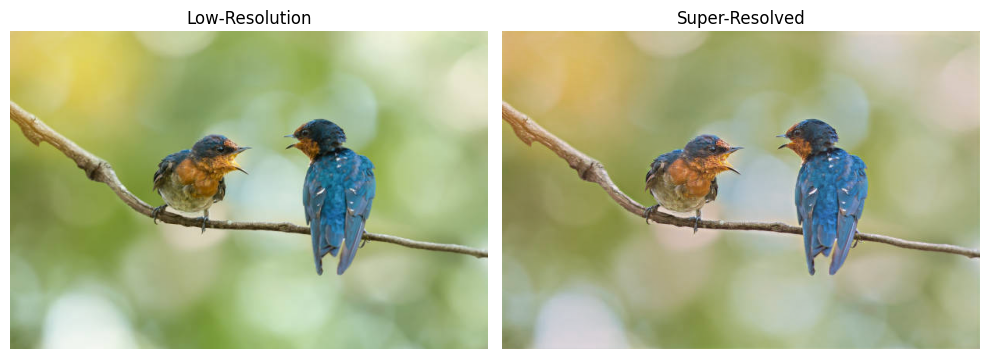

True

In [23]:
import tensorflow as tf
import numpy as np
import cv2
# from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# --- Configuration ---
# model_path = "srgan_generator_final.h5"
input_image_path = "./sample-blur-image.jpg"      # Path to LR image
scale = 4                                          # Scaling factor

# --- Load Generator Model ---
# final_generator = load_model(model_path, compile=False)

# --- Load and Preprocess LR Image ---
lr = cv2.imread(input_image_path)
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
lr = lr.astype(np.float32) / 127.5 - 1.0           # Normalize to [-1, 1]
lr_input = np.expand_dims(lr, axis=0)              # Shape: (1, H, W, 3)

# --- Generate Super-Resolution Image ---
sr = final_generator.predict(lr_input)[0]          # Shape: (H*scale, W*scale, 3)
sr = ((sr + 1.0) * 127.5).astype(np.uint8)         # Denormalize to [0, 255]

# --- Display and/or Save ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Low-Resolution")
plt.imshow(((lr + 1.0) * 127.5).astype(np.uint8))  # Denormalize for display
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Super-Resolved")
plt.imshow(sr)
plt.axis("off")

plt.tight_layout()
plt.show()

# Save result
cv2.imwrite("sr_output2.png", cv2.cvtColor(sr, cv2.COLOR_RGB2BGR))